In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from model import *
import torch
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from utils import *
from mmd import *
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## True posterior 

The first row in the plots is four samples in the noisy space $x' \sim x'|x$, together with the density p(x'|x).

We assume these points were sampled by first sampling a mixture component
then sampling the Gaussian to produce x then adding noise.

The posterior quantifies our belief in the location of x given the location
of the noised point.

Note that in the first three cases, because the x' points are low density we basically
conclude that we must have sampled a fairly low density x - hence the 'contracted'
appearance of the posterior distribution, which has been pulled towards the observation.

> Fortunately, given a noisy sample x' and an evaluation point x, we can evaluate the true density
  p(x|x') using Bayes rule: $p(x|x') = \frac{p(x'|x)p(x)}{p(x')}$
 Figure 1 shows the true posteriors given four different x′ where we use grid data in x-space to
 visualize the density.

The second row in the plots is

In [2]:
NOISE_LEVEL = 0.6

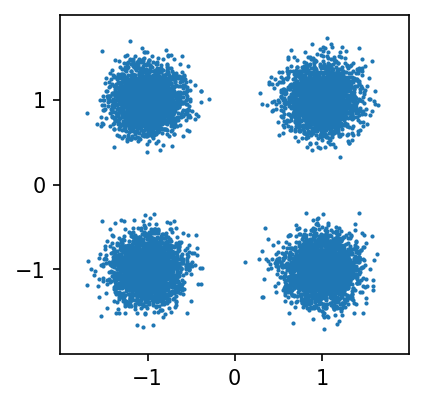

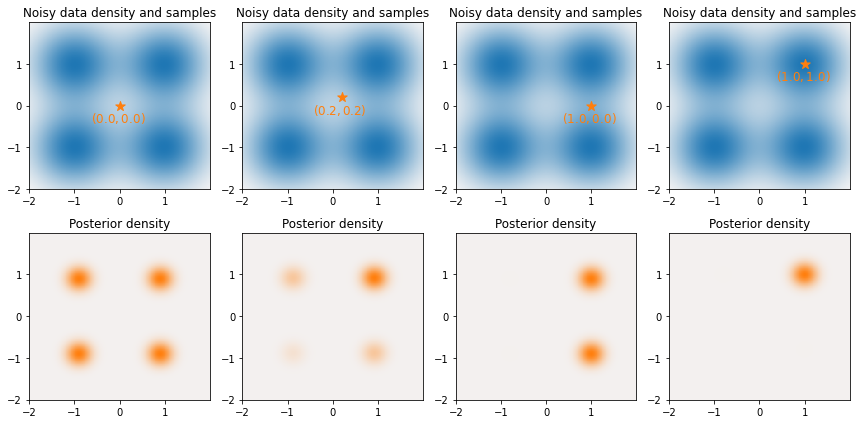

In [3]:
palette = sns.color_palette()

gmm_std=0.2
gmm=MoG4(std=gmm_std)

noise_std=NOISE_LEVEL
t_gmm_std=np.sqrt((noise_std**2+gmm_std**2))
t_gmm=MoG4(std=t_gmm_std)


def log_ptx_x(tx,x):
    """Probability of noisy data given clean data X=x."""
    return Normal(x,torch.ones_like(x)*noise_std).log_prob(tx).sum(-1)

def log_px_tx(x,tx):
    """Posterior probability of clean data given noisy data X'=tx, using Bayes rule.
    
    p(x|x'=tx) = p(x'=tx|x)p(x)/p(x'=tx)
    """
    return log_ptx_x(tx,x)+gmm.log_prob(x)-t_gmm.log_prob(tx)

X,Y=get_mesh()
# density of p(x) (GMM)
p_true_data=mesh_to_density(X,Y,lambda x:torch.exp(gmm.log_prob(x)))
# density of noisy p(x') (also a GMM)
p_noisy_data=mesh_to_density(X,Y,lambda x:torch.exp(t_gmm.log_prob(x)))


test_points=[torch.tensor([0.,0.]), torch.tensor([0.2,0.2]), torch.tensor([1.,0.]), torch.tensor([1.,1.])]
p_true_list=[mesh_to_density(X,Y,lambda x:torch.exp(log_px_tx(x,tx))) for tx in test_points]

dataset=torch.Tensor(gmm.sample([10000])).float()
get_plt()
plt.scatter(*dataset.T, alpha=1., color=palette[0], s=1);


def plot_pos(x, p, num=1, ax1=None, ax2=None):
    ax1.set_title("Noisy data density and samples")
    ax1.pcolormesh(X, Y, p_noisy_data.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[0],as_cmap=True))
    ax1.scatter(x[0],x[1],marker='*',color=palette[1],s=100)
    ax1.text(x[0]-0.64, x[1]-0.4, r'$('+str(x[0])+','+str(x[1])+')$', fontdict=get_font(palette[1]))
    ax2.set_title("Posterior density")
    ax2.pcolormesh(X, Y, p.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[1],as_cmap=True))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for num, point in enumerate(test_points):
    plot_pos(point.numpy(), p_true_list[num].numpy(),num+1, ax1=axes[0, num], ax2=axes[1, num])
plt.tight_layout()
plt.show()

# Denoising score matching to learn the mean

In [4]:
opt={
    'epochs':100,
    'batch_size':100,
    'test_batch_size':100,
    'gibbs_steps':10000,
    'device':'cpu',
    'noise_std': NOISE_LEVEL,
    'x_dim':2,
    'layer_num':3,
    'lr':1e-4,
    'act':'swish',
    'seed':0,
}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


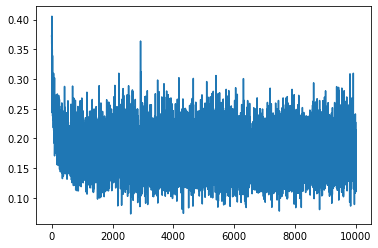

In [5]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model2=DenoisingEBM(opt)
loss_list=[]
model2.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model2.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        denoised_x_mean=model2(noisy_x)
        loss= torch.mean((batch_x-denoised_x_mean)**2)
        loss.backward()
        model2.optimizer.step()
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()


We now have a trained EBM. We want to ask whether the learned energy correlates well with

  1. The true log probability log p(x)
  2. The noisy log probability log p(x') (which is what the model is actually approximating).

In the MoG case, the true energy conditioned on a mixture component is
$\tfrac{1}{2\sigma^2}\sum_i (x_i - \mu))$ and the noisy energy is $\tfrac{1}{2\sigma'^2}\sum_i (x_i - \mu)$
so, at least *within* mixture components the energies are clearly linearly related.

In high-density cases, one component will dominate and the linear relationship will be preserved

We also want to ask how the correlation varies across different noise levels, and how it is
affected by 

      i. learning a single model averaged across multiple energy levels, as in DSMBind,  
     ii. applying a 'clean energy' correction.

In [21]:
model2.eval()

def energy(x):
    with torch.no_grad():
        E = model2.net(x.float()).sum(-1)
    return -E

In [22]:
test_dataset = torch.Tensor(gmm.sample([10000])).float()
log_px = gmm.log_prob(test_dataset)
log_ptx = t_gmm.log_prob(test_dataset)
test_E = energy(test_dataset)

## Correlation between distribution densitites on points sampled from the data distribution

Text(0, 0.5, 'Energy')

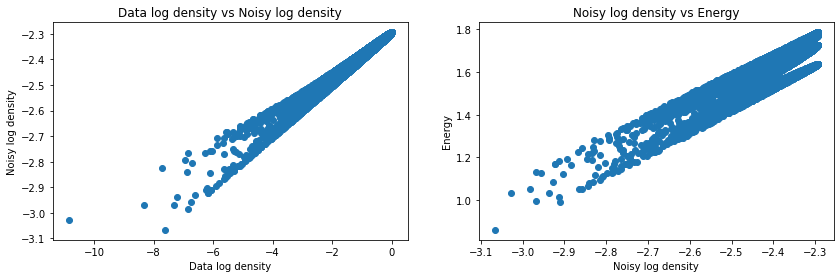

In [8]:
plt.figure(figsize=(14,4))
ax1 = plt.subplot(121)
ax1.scatter(log_px, log_ptx)
ax1.set_title("Data log density vs Noisy log density")
ax1.set_xlabel("Data log density")
ax1.set_ylabel("Noisy log density")

ax2 = plt.subplot(122)
ax2.set_title("Noisy log density vs Energy")
ax2.scatter(log_ptx, test_E)
ax2.set_xlabel("Noisy log density")
ax2.set_ylabel("Energy")

## Correlation between distribution densitites on grid points

Disagreement for mog mainly occurs in low-probability regions.

### 1. Noisy vs data distribution

In [9]:
X,Y=get_mesh()
mesh_data=torch.from_numpy(np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),1))
mesh_data.shape
# density of p(x) (GMM)
logp_true_mesh=gmm.log_prob(mesh_data)
# density of noisy p(x') (also a GMM)
logp_noisy_mesh=t_gmm.log_prob(mesh_data)

In [10]:
pearsonr(logp_true_mesh, logp_noisy_mesh)

PearsonRResult(statistic=0.9187118102765903, pvalue=0.0)

Text(0, 0.5, 'Noisy density')

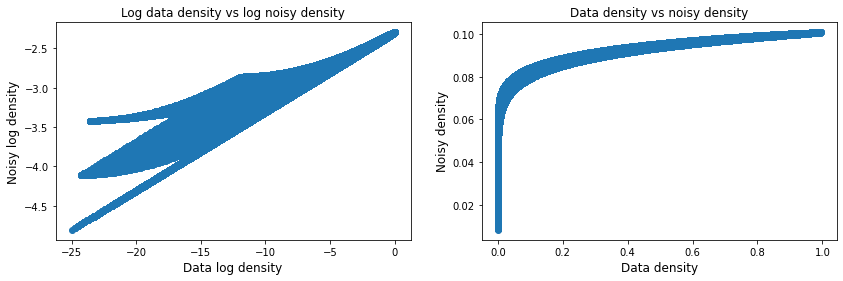

In [11]:
fig = plt.figure(figsize=(14,4))

ax1 = plt.subplot(121)
plt.scatter(logp_true_mesh, logp_noisy_mesh)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Noisy log density", fontsize=12)
ax1.set_title("Log data density vs log noisy density")
ax2 = plt.subplot(122)
plt.scatter(torch.exp(logp_true_mesh), torch.exp(logp_noisy_mesh))
ax2.set_title("Data density vs noisy density")
ax2.set_xlabel("Data density", fontsize=12)
ax2.set_ylabel("Noisy density", fontsize=12)

### 2. Learned energy vs data/noise distributions

**TODO: check whether I should be summing the final dimension... unclear**

In [12]:
energy_mesh = energy(mesh_data)

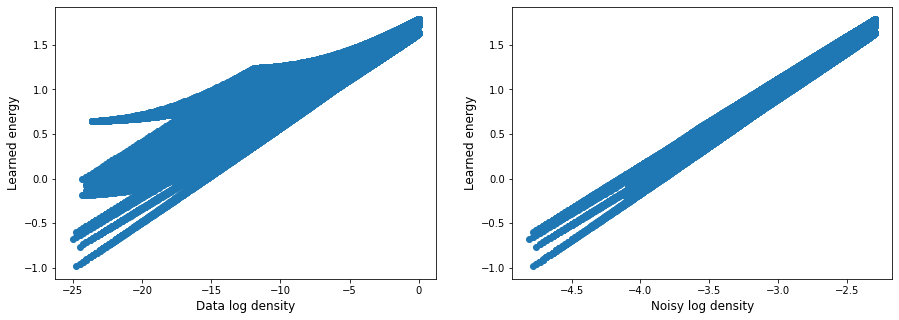

In [13]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
plt.scatter(logp_true_mesh, energy_mesh)
# ax1.set_title("")
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Learned energy", fontsize=12)
ax2 = plt.subplot(122)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Learned energy", fontsize=12)
plt.scatter(logp_noisy_mesh, energy_mesh)

## Estimating the data density given the learned energy and posterior approximation


Now we see whether a correction allows us to accurately compute / correct the density $p(x)$

$\text{log} p(x) = \int \text{log}\frac{p(x|x')p(x')}{p(x'|x)} p(x'|x) dx' = \text{log}\int\frac{p(x|x')p(x')}{p(x'|x)} p(x'|x) dx'$

$\text{log} p(x) \approx \frac{1}{N}\sum_i \text{log}\frac{p(x|x'_i)p(x'_i)}{p(x'_i|x)}$

N.B. we don't know the normalisation constant of p(x') - what effect does this have? maybe just a constant offset?

In [19]:
from torch.distributions import Independent, Normal

In [18]:
def clean_energy(x, log_posterior, log_noisy_x, num_samples=100):
    # suppose x is b, 2
    # then we need a bunch of normal distributions
    # the final dimension is interpreted as a non-batch dimension by Independent
    noise_dist = Independent(Normal(x, torch.ones_like(x)*NOISE_LEVEL), reinterpreted_batch_ndims=1)
    b = x.shape[0]
    x_noisy = noise_dist.sample((num_samples,))  # 100, b, 2
    x_noisy_flat = x_noisy.reshape(num_samples*b, 2)
    x_tiled = x.expand(num_samples, -1,-1).reshape(num_samples*b,2)

    # n.b. because noise_dist is in fact a batch of dists, input shape is different
    log_px = log_posterior(x_tiled, x_noisy_flat).reshape(100,b) + log_noisy_x(x_noisy_flat).reshape(100,b) - noise_dist.log_prob(x_noisy)
    # average over the samples
    return log_px.mean(0)
    

### 1. Using the true posterior p(x|x') and the learned noisy energy E(x')

In [25]:
E = energy(test_dataset)

In [16]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
clean_E = clean_energy(test_dataset, log_px_tx, energy)
E = energy(test_dataset)

Something a bit weird is happening here: we don't actually have a particularly good approximation
to the noisy density but it doesn't matter when we look at the clean density

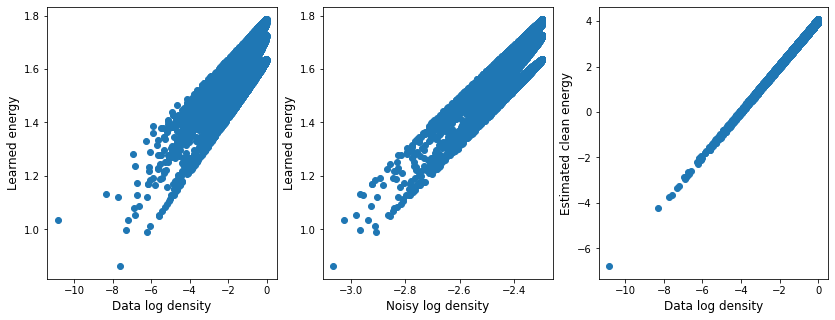

In [17]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(131)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px, E)

ax2 = plt.subplot(132)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_ptx, E)

ax3 = plt.subplot(133)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Estimated clean energy", fontsize=12)
plt.scatter(log_px, clean_E)

### 2. Using the approximated posterior q(x|x') and the learned noisy energy E(x')

There are two functions to approximate the posterior: 

**TODO: check shapes**

```
model2.logp_x_tx_isotropic_cov(x,x')
model2.logp_x_tx_full_cov(x,x')

```

TODO: consider batching these if we run into memory issues

In [18]:
test_dataset.shape

torch.Size([10000, 2])

In [19]:
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(test_dataset[:1000]).item())
clean_E_isotropic_cov = clean_energy(test_dataset[:1000], model2.logp_x_tx_isotropic_cov, energy)

Estimated isotropic variance: 0.16430258750915527


In [20]:
clean_E_full_cov = clean_energy(test_dataset[:1000], model2.logp_x_tx_full_cov, energy)

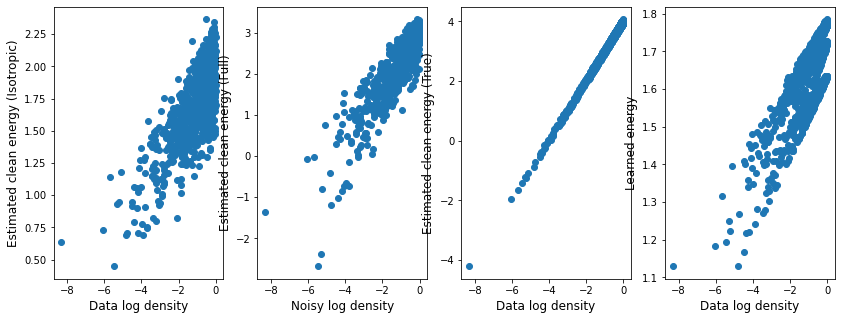

In [23]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(141)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Estimated clean energy (Isotropic)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_isotropic_cov)

ax2 = plt.subplot(142)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Estimated clean energy (Full)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_full_cov)

ax3 = plt.subplot(143)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Estimated clean energy (True)", fontsize=12)
plt.scatter(log_px[:1000], clean_E[:1000])

ax3 = plt.subplot(144)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px[:1000], E[:1000])

In [24]:
pearsonr(log_px[:1000], clean_E_full_cov)

PearsonRResult(statistic=0.8955434375548592, pvalue=0.0)

In [25]:
pearsonr(log_px[:1000], E[:1000])

PearsonRResult(statistic=0.8249888302613023, pvalue=1.3940473464388858e-249)

### 3. Using the true posterior p(x|x') and the true density of the noisy data p(x')

In [142]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
clean_E_gt = clean_energy(test_dataset, log_px_tx, t_gmm.log_prob)

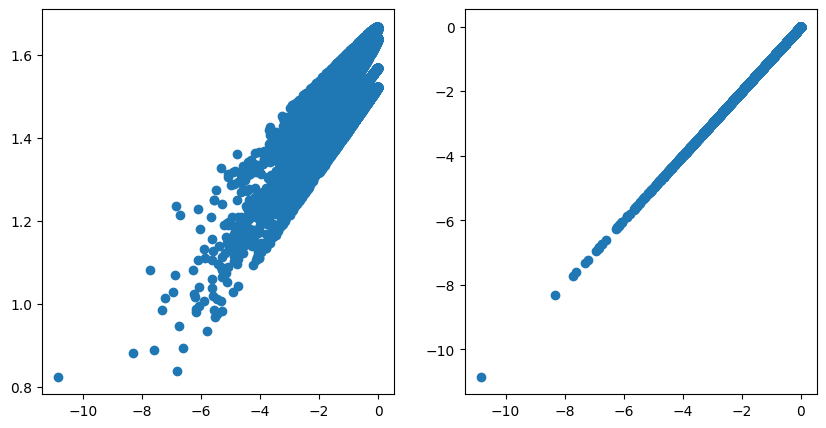

In [143]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
plt.scatter(log_px, E)
ax2 = plt.subplot(122)
plt.scatter(log_px, clean_E_gt)

## Using noise contrastive estimation to learn a better posterior approximation

n.b. to use isotropic version we first need to estimate isotropic variance

In [9]:
from nce import NCEDenoisingClassifier

In [16]:
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(dataset[:1000]).item())

Estimated isotropic variance: 0.19948722422122955


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]

torch.Size([100, 2])
tensor(0.9487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9707, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9728, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(1.0900, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(1.0048, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9358, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9655, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9251, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9782, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9839, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9383, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8724, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8984, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9463, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9063, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9295, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  1%|█▋                                                                                                                                                                            | 1/100 [00:01<01:48,  1.10s/it]

torch.Size([100, 2])
tensor(0.8634, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8747, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9252, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8324, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9453, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8757, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8750, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9827, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8961, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8450, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8283, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8869, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9240, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8939, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9164, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  2%|███▍                                                                                                                                                                          | 2/100 [00:02<01:47,  1.09s/it]

torch.Size([100, 2])
tensor(0.9194, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8798, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8055, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8764, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8382, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8578, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8540, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8005, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8067, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8382, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8334, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8214, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.9180, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  3%|█████▏                                                                                                                                                                        | 3/100 [00:03<01:45,  1.09s/it]

torch.Size([100, 2])
tensor(0.8424, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8208, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8093, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7898, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7983, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8008, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8044, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7529, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8006, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7858, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8273, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7976, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8017, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8020, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8315, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  4%|██████▉                                                                                                                                                                       | 4/100 [00:04<01:43,  1.08s/it]

torch.Size([100, 2])
tensor(0.7421, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7277, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7603, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7974, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7905, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7510, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7828, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7975, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7752, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7756, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7328, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8250, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7604, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8137, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7691, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  5%|████████▋                                                                                                                                                                     | 5/100 [00:05<01:42,  1.08s/it]

tensor(0.7553, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7660, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7989, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7851, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7798, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7726, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7744, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7482, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7671, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7894, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7525, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7618, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7461, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7601, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7448, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7760, grad_fn=<

  6%|██████████▍                                                                                                                                                                   | 6/100 [00:06<01:41,  1.08s/it]

tensor(0.7487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7661, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7883, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7589, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.8006, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7637, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7739, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7831, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7278, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7332, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7470, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7565, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7103, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7334, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7409, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7542, grad_fn=<

  7%|████████████▏                                                                                                                                                                 | 7/100 [00:07<01:40,  1.08s/it]

torch.Size([100, 2])
tensor(0.6947, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7262, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7344, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7041, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7476, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6931, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6787, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6967, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6691, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7370, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7407, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7077, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6724, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6882, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7561, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.7128, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

  8%|█████████████▉                                                                                                                                                                | 8/100 [00:08<01:39,  1.08s/it]

tensor(0.6528, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6967, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6674, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6370, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6645, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6145, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6252, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6606, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6675, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6229, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6519, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6235, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6857, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6774, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6972, grad_fn=<

  9%|███████████████▋                                                                                                                                                              | 9/100 [00:09<01:37,  1.08s/it]

tensor(0.6109, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6771, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5660, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5967, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5870, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5956, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6200, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6214, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5777, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5834, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5877, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5995, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6082, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5984, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5779, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5928, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5840, grad_fn=<

 10%|█████████████████▎                                                                                                                                                           | 10/100 [00:10<01:36,  1.07s/it]

torch.Size([100, 2])
tensor(0.5664, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5818, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5463, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5396, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5848, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5118, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6050, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5749, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6092, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6000, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5014, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5456, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5645, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.6066, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5586, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5526, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 11%|███████████████████                                                                                                                                                          | 11/100 [00:11<01:35,  1.07s/it]

torch.Size([100, 2])
tensor(0.5518, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5060, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4681, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5281, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4971, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5298, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5191, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5779, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5683, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5353, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5611, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5598, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4865, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5175, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5369, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5534, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 12%|████████████████████▊                                                                                                                                                        | 12/100 [00:12<01:34,  1.07s/it]

torch.Size([100, 2])
tensor(0.5397, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5184, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4792, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5171, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4720, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5219, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4785, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5642, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4869, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5393, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4952, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5000, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4862, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4827, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4708, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5152, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 13%|██████████████████████▍                                                                                                                                                      | 13/100 [00:14<01:33,  1.08s/it]

torch.Size([100, 2])
tensor(0.5411, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5363, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4891, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4889, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5309, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4693, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5388, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4817, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5273, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5566, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4368, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4589, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5171, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5276, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 14%|████████████████████████▏                                                                                                                                                    | 14/100 [00:15<01:32,  1.08s/it]

tensor(0.4291, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4815, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4797, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4381, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4936, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4981, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4756, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4665, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4632, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4615, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4640, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4815, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5248, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4542, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4545, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4582, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4747, grad_fn=<

 15%|█████████████████████████▉                                                                                                                                                   | 15/100 [00:16<01:31,  1.07s/it]

tensor(0.4350, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4637, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5359, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4932, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4457, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4412, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5122, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4701, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4572, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4840, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5265, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4590, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4648, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4760, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4591, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4604, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4527, grad_fn=<

 16%|███████████████████████████▋                                                                                                                                                 | 16/100 [00:17<01:30,  1.08s/it]

torch.Size([100, 2])
tensor(0.4509, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4830, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4732, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5008, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4667, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4839, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4615, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4996, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4948, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4687, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4348, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4518, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5882, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4718, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4650, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4534, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 17%|█████████████████████████████▍                                                                                                                                               | 17/100 [00:18<01:29,  1.08s/it]

torch.Size([100, 2])
tensor(0.4501, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4503, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4381, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4222, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4598, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4643, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4685, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4256, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4550, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4440, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4889, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4110, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4836, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3948, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4640, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 18%|███████████████████████████████▏                                                                                                                                             | 18/100 [00:19<01:28,  1.09s/it]

tensor(0.4989, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5911, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4545, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4790, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4705, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4734, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4329, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4602, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4118, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4667, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4141, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4837, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4178, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4794, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4444, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4754, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4166, grad_fn=<

 19%|████████████████████████████████▊                                                                                                                                            | 19/100 [00:20<01:28,  1.09s/it]

torch.Size([100, 2])
tensor(0.4576, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4851, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4672, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4382, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4178, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4665, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4095, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4252, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4387, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4495, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4014, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4106, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5361, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4676, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3768, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4475, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 20%|██████████████████████████████████▌                                                                                                                                          | 20/100 [00:21<01:27,  1.09s/it]

torch.Size([100, 2])
tensor(0.3844, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5004, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4386, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4565, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4643, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4397, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4220, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3884, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4324, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4324, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4782, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3992, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4257, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4856, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 21%|████████████████████████████████████▎                                                                                                                                        | 21/100 [00:22<01:26,  1.09s/it]

tensor(0.4367, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4749, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4321, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4882, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4559, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4322, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4339, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3860, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4203, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4215, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4125, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4517, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4182, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4674, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4246, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4337, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5015, grad_fn=<

 22%|██████████████████████████████████████                                                                                                                                       | 22/100 [00:23<01:25,  1.09s/it]

torch.Size([100, 2])
tensor(0.4048, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5378, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3981, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4187, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4066, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4630, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5154, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4191, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4291, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4193, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4451, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4556, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4299, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4073, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4729, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 23%|███████████████████████████████████████▊                                                                                                                                     | 23/100 [00:24<01:23,  1.09s/it]

torch.Size([100, 2])
tensor(0.4345, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3750, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3964, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4102, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4376, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4140, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4476, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4582, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4206, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4507, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5007, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4832, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4344, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4168, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4684, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5026, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 24%|█████████████████████████████████████████▌                                                                                                                                   | 24/100 [00:25<01:22,  1.09s/it]

torch.Size([100, 2])
tensor(0.4361, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4856, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4442, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4930, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4099, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4371, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4383, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4038, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3470, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5016, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4089, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3726, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4142, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5068, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4040, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 25%|███████████████████████████████████████████▎                                                                                                                                 | 25/100 [00:27<01:21,  1.08s/it]

torch.Size([100, 2])
tensor(0.4140, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4075, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4128, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4270, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4202, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4206, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4161, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3625, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4494, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4002, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5021, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4232, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3941, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4734, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4519, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4063, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 26%|████████████████████████████████████████████▉                                                                                                                                | 26/100 [00:28<01:19,  1.08s/it]

torch.Size([100, 2])
tensor(0.3956, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4445, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3758, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4749, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3774, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4509, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3860, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4084, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4264, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4424, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4469, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4111, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4682, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4159, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4262, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4789, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 27%|██████████████████████████████████████████████▋                                                                                                                              | 27/100 [00:29<01:18,  1.08s/it]

tensor(0.3778, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5405, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4319, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4670, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4316, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4313, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4361, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4242, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4268, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4471, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4525, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4017, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4183, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4921, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3628, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4217, grad_fn=<

 28%|████████████████████████████████████████████████▍                                                                                                                            | 28/100 [00:30<01:17,  1.08s/it]

torch.Size([100, 2])
tensor(0.4462, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3618, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4118, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4854, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4327, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4416, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4012, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4277, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3323, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4232, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4325, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4645, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4270, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4150, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4162, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3645, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 29%|██████████████████████████████████████████████████▏                                                                                                                          | 29/100 [00:31<01:16,  1.08s/it]

torch.Size([100, 2])
tensor(0.4442, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4639, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4297, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4005, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4449, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4468, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4028, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4094, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4194, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3837, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4211, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4546, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3751, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3741, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4451, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 30%|███████████████████████████████████████████████████▉                                                                                                                         | 30/100 [00:32<01:15,  1.08s/it]

torch.Size([100, 2])
tensor(0.4626, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5049, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4605, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3949, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4741, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4703, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4387, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4246, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4445, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4367, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4812, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4131, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4954, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4117, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3578, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5097, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 31%|█████████████████████████████████████████████████████▋                                                                                                                       | 31/100 [00:33<01:14,  1.08s/it]

torch.Size([100, 2])
tensor(0.4018, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3711, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4416, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4082, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3733, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4002, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4620, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4564, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4234, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4528, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3956, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4705, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3717, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4280, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4315, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 32/100 [00:34<01:13,  1.07s/it]

tensor(0.3440, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4102, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4795, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4663, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4270, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4152, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3905, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3482, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4080, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4151, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4689, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4688, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4247, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4540, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4238, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4736, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4708, grad_fn=<

 33%|█████████████████████████████████████████████████████████                                                                                                                    | 33/100 [00:35<01:12,  1.08s/it]

torch.Size([100, 2])
tensor(0.3940, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4406, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3943, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4224, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4559, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4646, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4431, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4021, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4092, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3958, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3970, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4777, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3538, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4617, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3914, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4150, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 34%|██████████████████████████████████████████████████████████▊                                                                                                                  | 34/100 [00:36<01:11,  1.08s/it]

tensor(0.4798, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4135, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4811, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4291, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4586, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4424, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3952, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4207, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4394, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4510, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4060, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4472, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4270, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4250, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4384, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4502, grad_fn=<

 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 35/100 [00:37<01:10,  1.08s/it]

torch.Size([100, 2])
tensor(0.3651, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4578, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4467, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4718, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4267, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4568, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4256, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4678, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5550, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3874, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3921, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3625, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4076, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4019, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4546, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4485, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 36/100 [00:38<01:09,  1.08s/it]

torch.Size([100, 2])
tensor(0.3455, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4515, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4761, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4055, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4122, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3851, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4247, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4058, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3675, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4114, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5135, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4159, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3809, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4621, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4542, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 37%|████████████████████████████████████████████████████████████████                                                                                                             | 37/100 [00:40<01:08,  1.08s/it]

torch.Size([100, 2])
tensor(0.4535, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4278, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4686, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4841, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4510, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3509, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4642, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4421, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4390, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5015, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4031, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4028, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3625, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4110, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4334, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 38/100 [00:41<01:07,  1.08s/it]

torch.Size([100, 2])
tensor(0.4125, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4142, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4339, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3697, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4342, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3677, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4378, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4538, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4147, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4257, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4025, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4716, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4612, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4398, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4242, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4401, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 39/100 [00:42<01:06,  1.08s/it]

torch.Size([100, 2])
tensor(0.4148, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4038, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3921, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4070, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4329, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4160, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4171, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4391, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3890, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4120, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4161, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3936, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3931, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4370, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 40/100 [00:43<01:04,  1.08s/it]

torch.Size([100, 2])
tensor(0.4380, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4120, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4713, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4499, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3933, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4086, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4200, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3593, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3729, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3801, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4788, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4440, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4301, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4193, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4966, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4086, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                      | 41/100 [00:44<01:03,  1.08s/it]

torch.Size([100, 2])
tensor(0.3924, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3865, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4872, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3842, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4729, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4266, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3814, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4192, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4154, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4099, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4344, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4693, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4223, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4367, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3996, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4570, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 42/100 [00:45<01:02,  1.08s/it]

tensor(0.3496, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4548, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4708, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3864, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4838, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3669, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4119, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4282, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4561, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4158, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3783, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4734, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4406, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3835, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4115, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4530, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4241, grad_fn=<

 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 43/100 [00:46<01:01,  1.08s/it]

torch.Size([100, 2])
tensor(0.3756, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3604, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4452, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3738, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4434, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4175, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4592, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3994, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4074, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4306, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3837, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3397, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4575, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3650, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 44/100 [00:47<01:00,  1.08s/it]

torch.Size([100, 2])
tensor(0.3752, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4297, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3732, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4679, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4097, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3780, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5015, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4089, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4222, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4196, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4614, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4314, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5615, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4733, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3945, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4415, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 45/100 [00:48<00:59,  1.08s/it]

torch.Size([100, 2])
tensor(0.4602, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4218, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4525, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4363, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4539, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4271, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3867, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3996, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3846, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4251, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3885, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4216, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4298, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4703, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3877, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4116, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                             | 46/100 [00:49<00:58,  1.08s/it]

tensor(0.4755, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3619, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4538, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4138, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3914, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3968, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4869, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4041, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4184, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4198, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4111, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3250, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4564, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4374, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3598, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4305, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3703, grad_fn=<

 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 47/100 [00:50<00:57,  1.08s/it]

torch.Size([100, 2])
tensor(0.3997, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4588, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4016, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4497, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3978, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3906, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4022, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3353, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4265, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3995, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5225, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3718, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4120, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4225, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 48/100 [00:51<00:56,  1.08s/it]

torch.Size([100, 2])
tensor(0.4296, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3990, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4434, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4588, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4303, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4078, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4005, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4743, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4692, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4375, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4312, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4575, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4599, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4351, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3818, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 49/100 [00:52<00:55,  1.08s/it]

tensor(0.4324, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4167, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4211, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4329, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4008, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4299, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3843, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4790, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3951, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4823, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4372, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3879, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4341, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4429, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4444, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4627, grad_fn=<

 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 50/100 [00:54<00:54,  1.08s/it]

tensor(0.3800, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4710, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4077, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4367, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4647, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4735, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4235, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4798, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4327, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3964, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3968, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3597, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4248, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4490, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4556, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4331, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4318, grad_fn=<

 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 51/100 [00:55<00:53,  1.08s/it]

torch.Size([100, 2])
tensor(0.3961, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4523, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3886, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4497, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5346, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4494, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4443, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4382, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3858, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4848, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4310, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3933, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4230, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4221, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4886, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4266, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 52/100 [00:56<00:51,  1.08s/it]

tensor(0.4861, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4654, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4405, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4227, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4171, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3664, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4432, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4152, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3963, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4147, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3462, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4583, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4375, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4237, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4558, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4274, grad_fn=<

 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 53/100 [00:57<00:50,  1.08s/it]

torch.Size([100, 2])
tensor(0.4765, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4558, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4185, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3757, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4483, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3589, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5074, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5017, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4370, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3828, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4052, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4356, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3789, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4883, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4234, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 54/100 [00:58<00:50,  1.09s/it]

torch.Size([100, 2])
tensor(0.3972, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5062, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3715, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4224, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4398, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3931, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4086, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3892, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4231, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3870, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4799, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4304, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3929, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3933, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5079, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 55/100 [00:59<00:49,  1.09s/it]

tensor(0.4163, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4285, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4220, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4329, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4007, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4552, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4392, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4295, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3879, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4428, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4445, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4397, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4501, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4390, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4368, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3666, grad_fn=<

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 56/100 [01:00<00:47,  1.09s/it]

torch.Size([100, 2])
tensor(0.3681, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4272, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4499, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4109, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4010, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3671, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4146, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3914, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4974, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4017, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3974, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4620, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4319, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4565, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3622, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 57/100 [01:01<00:47,  1.10s/it]

torch.Size([100, 2])
tensor(0.3817, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4829, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3734, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4212, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4140, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4668, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4276, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4056, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4983, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4927, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4186, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4328, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3512, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4060, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5055, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 58/100 [01:02<00:45,  1.09s/it]

tensor(0.3279, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4400, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4390, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4345, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3873, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4561, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4709, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3945, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4957, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3725, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4431, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4667, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4308, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3998, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4442, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3512, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3586, grad_fn=<

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 59/100 [01:03<00:44,  1.09s/it]

torch.Size([100, 2])
tensor(0.3946, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4337, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4699, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3836, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4269, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4319, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3728, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4298, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4558, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3947, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4350, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4127, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4498, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3919, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 60/100 [01:04<00:43,  1.09s/it]

tensor(0.4531, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4739, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4107, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4104, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4233, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3654, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3502, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4540, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4469, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4859, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4070, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4654, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5125, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4263, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4039, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4170, grad_fn=<

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 61/100 [01:06<00:42,  1.08s/it]

torch.Size([100, 2])
tensor(0.4617, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4673, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4441, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4413, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4581, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4175, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4755, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4871, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4516, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4576, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4840, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4074, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4324, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4348, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4349, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4173, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/100 [01:07<00:41,  1.08s/it]

tensor(0.3891, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4076, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4792, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3906, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3830, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3770, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4287, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4356, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4841, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4029, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4141, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3843, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4023, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4050, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4099, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4790, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4679, grad_fn=<

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 63/100 [01:08<00:40,  1.09s/it]

tensor(0.4099, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4201, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4082, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4460, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3915, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3619, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3900, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3909, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4379, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3892, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4296, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4277, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4612, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4317, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4289, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4290, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4238, grad_fn=<

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/100 [01:09<00:39,  1.09s/it]

torch.Size([100, 2])
tensor(0.4420, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4701, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4029, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4429, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4700, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4079, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4381, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4540, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4475, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4584, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4365, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4481, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4009, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3175, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3805, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4095, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/100 [01:10<00:38,  1.09s/it]

tensor(0.3491, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4355, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4731, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4211, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3554, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4064, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4721, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4604, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4558, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4697, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3756, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3874, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3999, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3614, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4634, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3936, grad_fn=<

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 66/100 [01:11<00:37,  1.09s/it]

torch.Size([100, 2])
tensor(0.4185, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4246, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4217, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4479, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4413, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3495, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4423, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4882, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4717, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4815, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5336, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4468, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4770, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4518, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3850, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 67/100 [01:12<00:35,  1.09s/it]

torch.Size([100, 2])
tensor(0.3991, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4074, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4714, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4072, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4758, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4881, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3566, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4411, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4352, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4371, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4290, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4168, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4693, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3579, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4306, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4543, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 68/100 [01:13<00:34,  1.08s/it]

tensor(0.3719, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4813, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4928, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4262, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5485, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3407, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4623, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4531, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3581, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3871, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4158, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4060, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4031, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4335, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4459, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4227, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3874, grad_fn=<

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 69/100 [01:14<00:33,  1.08s/it]

torch.Size([100, 2])
tensor(0.4068, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3445, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4908, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4529, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3864, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4222, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3675, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4548, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4168, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3730, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3911, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4307, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3872, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3670, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4280, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 70/100 [01:15<00:32,  1.08s/it]

tensor(0.3559, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4791, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3659, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3769, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4160, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3771, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3243, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4627, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4911, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4191, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3792, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3645, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3986, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4232, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4629, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4602, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4323, grad_fn=<

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 71/100 [01:16<00:31,  1.08s/it]

tensor(0.4333, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4495, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4692, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3739, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4805, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3529, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4800, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4459, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4535, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4159, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4414, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3776, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4401, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4076, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4290, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4118, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4335, grad_fn=<

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 72/100 [01:17<00:30,  1.07s/it]

torch.Size([100, 2])
tensor(0.4039, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4360, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3980, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4332, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4343, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4829, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4063, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4568, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4250, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4399, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3477, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3590, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4135, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4278, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3638, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3434, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 73/100 [01:19<00:28,  1.07s/it]

torch.Size([100, 2])
tensor(0.3844, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3626, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3893, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4158, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4150, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3698, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4620, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4954, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3839, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3826, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4474, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3926, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4550, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4298, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 74/100 [01:20<00:27,  1.07s/it]

tensor(0.4072, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4232, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3921, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3710, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3837, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3838, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4305, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4164, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4390, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4518, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4986, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4078, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4193, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4246, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4513, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4515, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4357, grad_fn=<

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 75/100 [01:21<00:26,  1.07s/it]

torch.Size([100, 2])
tensor(0.3735, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4166, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3945, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4317, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3713, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3809, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4272, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4037, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4163, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4416, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4147, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3794, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4138, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4301, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4586, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4830, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 76/100 [01:22<00:25,  1.07s/it]

torch.Size([100, 2])
tensor(0.4136, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4021, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3785, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4113, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4533, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4443, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4174, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3808, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4218, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4573, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4341, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3879, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4006, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4442, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4245, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4319, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 77/100 [01:23<00:24,  1.07s/it]

torch.Size([100, 2])
tensor(0.4978, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4037, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3790, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4084, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4139, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4740, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3598, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4990, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3987, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3853, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3869, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4941, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3633, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4224, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4096, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 78/100 [01:24<00:23,  1.07s/it]

tensor(0.4250, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4511, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3805, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3356, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4117, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4568, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3966, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4243, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4077, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3904, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4252, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4469, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3835, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4566, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4169, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3983, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4964, grad_fn=<

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 79/100 [01:25<00:22,  1.07s/it]

torch.Size([100, 2])
tensor(0.4108, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4562, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4218, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4253, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4771, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4142, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3822, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3976, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4658, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4282, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4630, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4063, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4808, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4255, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3890, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 80/100 [01:26<00:21,  1.07s/it]

tensor(0.3883, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4363, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4125, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4002, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4903, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3915, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4803, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3992, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4997, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4125, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4053, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4079, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4252, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4091, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4555, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3936, grad_fn=<

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 81/100 [01:27<00:20,  1.07s/it]

tensor(0.4112, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3895, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4476, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4101, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3967, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5021, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4090, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3789, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4107, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4029, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4382, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3581, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3957, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5191, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4058, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4454, grad_fn=<

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 82/100 [01:28<00:19,  1.08s/it]

torch.Size([100, 2])
tensor(0.4111, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4619, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4637, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3370, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4345, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3598, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4563, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4114, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4839, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3969, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4189, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3874, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4340, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4069, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4620, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 83/100 [01:29<00:18,  1.08s/it]

torch.Size([100, 2])
tensor(0.3448, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4488, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3529, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4536, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3882, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4903, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4296, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4719, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4025, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4234, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4022, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4035, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4646, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4353, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4381, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4434, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 84/100 [01:30<00:17,  1.08s/it]

tensor(0.4515, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4245, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3972, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4306, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3816, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3958, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4244, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5235, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3528, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4296, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4526, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4196, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4772, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3807, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3957, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4070, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4224, grad_fn=<

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 85/100 [01:31<00:16,  1.08s/it]

torch.Size([100, 2])
tensor(0.4314, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3856, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4657, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4114, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4054, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4104, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3715, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3999, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4054, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4406, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3951, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4045, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4223, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4744, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4248, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3888, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 86/100 [01:32<00:15,  1.08s/it]

torch.Size([100, 2])
tensor(0.4010, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4157, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4494, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3655, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4277, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4204, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4199, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4097, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4517, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4190, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4085, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3923, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4923, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5081, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4015, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 87/100 [01:34<00:14,  1.08s/it]

tensor(0.3876, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4053, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4193, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4153, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4571, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3961, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3814, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3934, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4301, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4182, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4553, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3932, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3627, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3737, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4814, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3803, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4466, grad_fn=<

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 88/100 [01:35<00:12,  1.08s/it]

torch.Size([100, 2])
tensor(0.3771, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3754, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4136, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4246, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4033, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4286, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4011, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3737, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4502, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4702, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4945, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3764, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4574, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4714, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4394, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4686, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 89/100 [01:36<00:11,  1.08s/it]

torch.Size([100, 2])
tensor(0.5137, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3931, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4406, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3972, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3941, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4356, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5155, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3801, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3487, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4955, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3588, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3939, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3913, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3937, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4230, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 90/100 [01:37<00:10,  1.08s/it]

torch.Size([100, 2])
tensor(0.3781, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3561, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3834, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3972, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4208, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4203, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4052, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4282, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4239, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3988, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3843, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4189, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4636, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3924, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4230, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4158, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 91/100 [01:38<00:09,  1.08s/it]

tensor(0.4193, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3909, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5087, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4085, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4033, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4426, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3779, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3939, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4088, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3987, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3903, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4185, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3610, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4982, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3891, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4010, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4547, grad_fn=<

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 92/100 [01:39<00:08,  1.08s/it]

torch.Size([100, 2])
tensor(0.4857, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4469, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4995, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3889, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4422, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3958, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3594, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4078, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4259, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4871, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4480, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4512, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4217, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4000, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3768, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3764, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 93/100 [01:40<00:07,  1.08s/it]

torch.Size([100, 2])
tensor(0.4217, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3758, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4023, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3578, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3168, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4803, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4576, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4804, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4320, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4306, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4640, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4318, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4186, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3732, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3647, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4135, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 94/100 [01:41<00:06,  1.08s/it]

torch.Size([100, 2])
tensor(0.4744, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4409, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3999, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3712, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4580, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4739, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3949, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4489, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4297, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4577, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4987, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4072, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4530, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4323, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3847, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4007, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 95/100 [01:42<00:05,  1.07s/it]

tensor(0.4171, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3664, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4358, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4907, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4312, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4626, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3709, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4053, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4244, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4286, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3776, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4446, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.5078, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4627, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3780, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4493, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4986, grad_fn=<

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 96/100 [01:43<00:04,  1.07s/it]

torch.Size([100, 2])
tensor(0.4195, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3605, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3931, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4364, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4082, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3932, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4358, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4160, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3251, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4508, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3602, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4707, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3780, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4084, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4128, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 97/100 [01:44<00:03,  1.07s/it]

tensor(0.3963, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4609, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3969, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4434, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4918, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3884, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4110, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4187, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4417, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4392, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4745, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4426, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4518, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4129, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3559, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3691, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4394, grad_fn=<

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 98/100 [01:45<00:02,  1.07s/it]

tensor(0.3562, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4587, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4483, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4075, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4728, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4277, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3450, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4024, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4354, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4325, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4035, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4242, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4069, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4577, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4786, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3863, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4205, grad_fn=<

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [01:46<00:01,  1.07s/it]

torch.Size([100, 2])
tensor(0.4516, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4062, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3723, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3774, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3613, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3718, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3213, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4210, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3635, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4037, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3733, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4268, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4604, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3572, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4473, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3775, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
ten

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]

torch.Size([100, 2])
tensor(0.3864, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4420, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4001, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3678, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4506, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4025, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.4753, grad_fn=<MeanBackward0>)
torch.Size([100, 2])
tensor(0.3633, grad_fn=<MeanBackward0>)


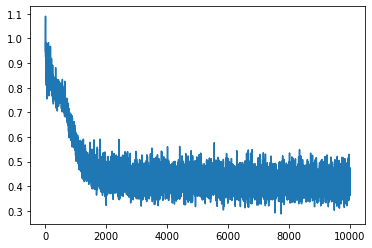

In [17]:

np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

nce_model = NCEDenoisingClassifier(opt)
model2.eval()

loss_list=[]
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        nce_model.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        
        # N.B. it would actually be better to compute the distribution
        # and then sample / log prob because otherwise recomputing the distribution is expensive
        # with full cov i got non-positive definite covariance issue
        q_x_dist = model2.dist_p_x_tx_isotropic_cov(noisy_x)
        q_x_sample = q_x_dist.sample()  # the 'noise distribution for nce'. can we get log probs without recomputing?

        # conditioning variable is always noisy_x; prediction variables are q_x_sample and batch_x
        inputs = torch.cat([q_x_sample, batch_x], axis=0)  # shape (batch_size*2, x_dim)
        noisy_x_repeated = torch.cat([noisy_x, noisy_x], axis=0)  # shape (batch_size*2, x_dim)
        nce_energy = nce_model(inputs, noisy_x_repeated)  # shape (batch_size*2,)
        
        noise_log_q = q_x_dist.log_prob(q_x_sample)
        data_log_q = q_x_dist.log_prob(batch_x)
        
        logit = nce_energy - torch.cat((noise_log_q, data_log_q), axis=0)
        targets = torch.cat([torch.zeros(opt['batch_size']), torch.ones(opt['batch_size'])], axis=0).to(opt['device'])

        loss = F.binary_cross_entropy_with_logits(logit, targets).mean()

        loss.backward()
        nce_model.optimizer.step()
        loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()

In [27]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
nce_model.eval()
clean_E_nce = clean_energy(test_dataset, nce_model, t_gmm.log_prob)

In [28]:
clean_E_nce.d

tensor([-0.6726, -0.4251, -0.4109,  ..., -1.0025, -0.0657, -2.7836],
       grad_fn=<MeanBackward1>)

PearsonRResult(statistic=0.7985222494424566, pvalue=0.0) PearsonRResult(statistic=0.9845585859306376, pvalue=0.0)


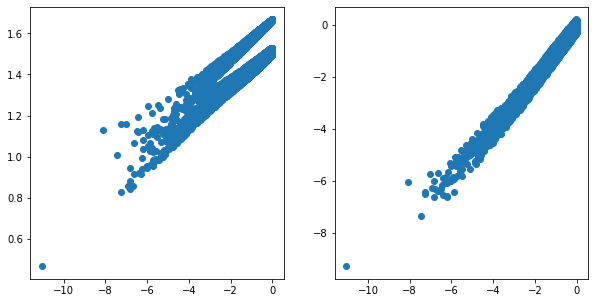

In [30]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
plt.scatter(log_px, E)
ax2 = plt.subplot(122)
# Question: why does clean_E_nce require grad?
plt.scatter(log_px, clean_E_nce.detach().cpu().numpy())
print(pearsonr(log_px, E), pearsonr(log_px, clean_E_nce.detach().cpu().numpy()))